In [ ]:
# Accedo a Google Drive
from google.colab import drive
drive.mount(r'/content/drive')

# Importo librerías que vamos a usar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Accedo a la PWT. En este caso, yo la tengo cargada en mi drive :)
file_path = '/content/drive/MyDrive/Colab Notebooks/economic-growth/pwt1001.xlsx' # Modificar el path según sea necesario
pwt = pd.read_excel(file_path, sheet_name="Data") # Poner el nombre de la hoja tal cual. Con esto armamos un dataframe

# Agrego como columnas las variables a calcular
pwt['S']=pwt['rdana']-pwt['rconna'] # Ahorro
pwt['Y per cápita']=pwt['rgdpna']/pwt['pop'] # PBI per cápita
pwt['Tasa de ahorro']=pwt['S']/pwt['rgdpna'] # Tasa de ahorro
pwt['Share de capital'] = 1 - pwt['labsh'] # Share de Capital
pwt['K per cápita']= pwt['rnna']/pwt['pop'] # Capital per cápita

# Tasas de crecimiento (calculadas como variaciones porcentuales, revisar)
pwt['n']= pwt['pop'].pct_change() * 100 # Tasa de crecimiento poblacional
pwt['Tasa de crecimiento de yt'] = pwt['Y per cápita'].pct_change() * 100 # Tasa de crecimiento del pbi per cápita
pwt['Tasa de crecimiento de kt'] = pwt['K per cápita'].pct_change() * 100 # Tasa de crecimiento del capital per cápita

# The motherfucking residuo de Solow
pwt['PTF']= (pwt['Tasa de crecimiento de yt']) - (pwt['n'] * pwt['labsh']) - (pwt['Tasa de crecimiento de kt'] * pwt['Share de capital'])

# print(pwt) # Descomentar (sin dejar espacios!) para ver cómo quedó la pwt con los agregados

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


  countrycode          country_1990  log_pwt_1990          country_2019  \
0         ABW                 ARUBA     10.788750                 ARUBA   
1         AGO                ANGOLA      8.018731                ANGOLA   
2         AIA              ANGUILLA     10.234190              ANGUILLA   
3         ALB               ALBANIA      8.210996               ALBANIA   
4         ARE  UNITED ARAB EMIRATES     11.883394  UNITED ARAB EMIRATES   

   log_pwt_2019  tasa_crecimiento_acumulado  
0     10.392490                   -0.013664  
1      8.876206                    0.029568  
2      9.627597                   -0.020917  
3      9.436024                    0.042242  
4     11.099116                   -0.027044  
                                OLS Regression Results                                
Dep. Variable:     tasa_crecimiento_acumulado   R-squared:                       0.102
Model:                                    OLS   Adj. R-squared:                  0.097
Method:     

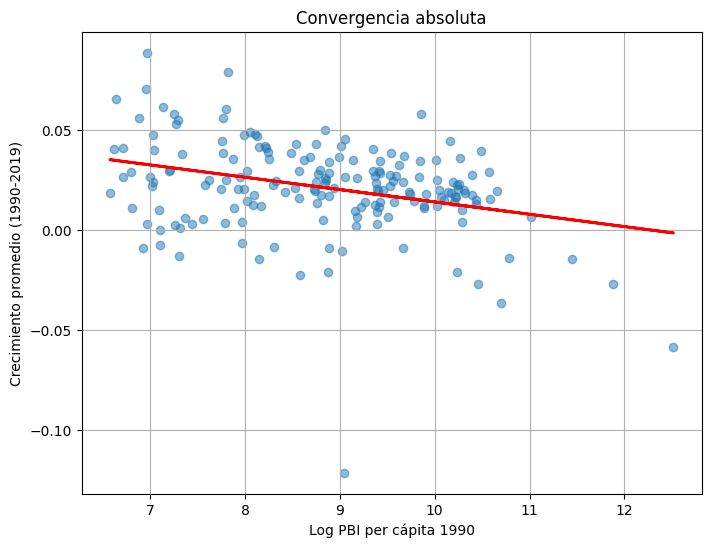

In [ ]:
#  Convergencia

# Preparación para análisis de convergencia
# Para esto necesitamos preparar un nuevo dataframe apto modelos, limpio
# Limpiamos la PWT para no tener datos faltantes :)
valores_faltantes_columna = pwt.isnull().sum()
columnas_a_descartar = valores_faltantes_columna[valores_faltantes_columna > 52000].index.tolist()
pwt_intermedia = pwt.drop(columns=columnas_a_descartar)
pwt_clean = pwt_intermedia #.dropna()
# Con esto obtenemos el df apto modelos ;)


# Convergencia absoluta

# Preparamos los datos para la regresión

# Filtramos por año de inicio y fin
pwt_1990 = pwt_clean[pwt_clean["year"] == 1990].copy()
pwt_2019 = pwt_clean[pwt_clean["year"] == 2019].copy()

# Normalizamos nombres de países
pwt_1990["country"] = pwt_1990["country"].str.strip().str.upper()
pwt_2019["country"] = pwt_2019["country"].str.strip().str.upper()

# Calculamos log del PBI per cápita
pwt_1990["log_pwt_1990"] = np.log(pwt_1990["rgdpo"] / pwt_1990["pop"])
pwt_2019["log_pwt_2019"] = np.log(pwt_2019["rgdpo"] / pwt_2019["pop"])

# Eliminamos filas con NaN o Inf en los logs
pwt_1990 = pwt_1990.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_pwt_1990"])
pwt_2019 = pwt_2019.replace([np.inf, -np.inf], np.nan).dropna(subset=["log_pwt_2019"])

# Merge usando countrycode como clave principal
pwt_merge = pd.merge(
    pwt_1990[["countrycode", "country", "log_pwt_1990"]],
    pwt_2019[["countrycode", "country", "log_pwt_2019"]],
    on="countrycode",
    suffixes=("_1990", "_2019")
)

# Calculo la tasa de crecimiento acumulado
pwt_merge["tasa_crecimiento_acumulado"] = (
    pwt_merge["log_pwt_2019"] - pwt_merge["log_pwt_1990"]
) / (2019 - 1990)

# Vista rápida
print(pwt_merge.head())


# display(pwt_merge) # verificación (descomentar de ser necesario)

# Regresión simple
import statsmodels.api as sm

if not pwt_merge.empty:
    y = pwt_merge["tasa_crecimiento_acumulado"]
    x = sm.add_constant(pwt_merge["log_pwt_1990"])
    model = sm.OLS(y, x).fit()
    print(model.summary())
else:
    print("El DataFrame de merge está vacío, revisar claves de unión.")

# Analizamos graficamente
plt.figure(figsize=(8, 6))
plt.scatter(pwt_merge["log_pwt_1990"],
            pwt_merge["tasa_crecimiento_acumulado"], alpha=0.5) # Nube de puntos
plt.plot(pwt_merge["log_pwt_1990"], model.predict(x),
         color='red', linewidth=2) # Linea de regresión

# Formato del gráfico
plt.xlabel('Log PBI per cápita 1990')
plt.ylabel('Crecimiento promedio (1990-2019)')
plt.title('Convergencia absoluta')
plt.grid(True)
plt.show()

In [ ]:
# Convergencia segun país, basado en el Mankiw, Romer y Weil (1992)

# No calcularemos nuevamente la tasa de crecimiento de la población ni la tasa de ahorro, ya que las incluimos como columnas

# Agregamos las variables de control al dataset con un grupby(), agg()

resumen_paises = pwt_clean.groupby('countrycode').agg(
  mean_n = ('n', 'mean'),
  mean_s = ('S', 'mean'),
  max_hc = ('hc', 'max'), # Introducimos capital humano siguiendo el paper
 ).reset_index() # Reseteamos el indice antes del merge para utilizar countrycode como llave

# Hacemos la regresión condicional

regression_data = pwt_merge.merge(resumen_paises, on='countrycode', how='left')

# Merge
regression_data = pwt_merge.merge(resumen_paises, on='countrycode', how='left')

# Variables dependientes e independientes
y = regression_data['tasa_crecimiento_acumulado']
x_cols = ['log_pwt_1990', 'mean_s', 'mean_n', 'max_hc']
X = sm.add_constant(regression_data[x_cols])

# Reemplazamos inf con NaN y eliminamos filas con NaN
X = X.replace([np.inf, -np.inf], np.nan)
reg_data = pd.concat([y, X], axis=1).dropna()

# Definimos nuevamente X e y limpios
y_clean = reg_data['tasa_crecimiento_acumulado']
X_clean = reg_data[x_cols + ['const']]

# Regresión
model = sm.OLS(y_clean, X_clean).fit()
print(model.summary())

                                OLS Regression Results                                
Dep. Variable:     tasa_crecimiento_acumulado   R-squared:                       0.122
Model:                                    OLS   Adj. R-squared:                  0.097
Method:                         Least Squares   F-statistic:                     4.850
Date:                        Sat, 13 Sep 2025   Prob (F-statistic):            0.00108
Time:                                20:10:44   Log-Likelihood:                 361.26
No. Observations:                         145   AIC:                            -712.5
Df Residuals:                             140   BIC:                            -697.6
Df Model:                                   4                                         
Covariance Type:                    nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------